# Import and install libs

In [1]:
import os
import zipfile
import cv2
import shutil
import numpy as np
from PIL import Image
import torch
import random
import torch.nn as nn 
import os
import torch.nn.functional as F
from tqdm import tqdm 
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

from IPython.display import clear_output
import seaborn as sns 
import matplotlib.pyplot as plt

#graphics settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
sns.set_style('darkgrid')

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [3]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


# Load dataset

In [4]:
domains = ['art_painting', 'cartoon', 'photo', 'sketch']
path = ''
N_CLASSES = 7

In [5]:
def get_paths_and_labels(dataset_types, domain):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: list of 'train', 'val', 'test'
      domain: one of 'art_painting', 'cartoon', 'photo', 'sketch'
    '''

    path_dict = {
        'val' : 'crossval_kfold',
        'test' : 'test_kfold',
        'train' : 'train_kfold'
    }
    paths = []
    labels = []
    for ds_type in dataset_types:
        filepath = path + 'labels/' + domain + '_' + path_dict[ds_type] + '.txt'
        f = open(filepath, 'r')
        lines = f.readlines()
        f.close()
        lines = [l.split() for l in lines]
        cur_paths, cur_labels = zip(*lines)
        cur_labels = [int(l) for l in cur_labels]
        paths += cur_paths 
        labels += cur_labels 
    labels = torch.Tensor(labels) - 1
    return paths, labels

In [6]:
paths, labels  = get_paths_and_labels(['train'], 'cartoon')
print(paths[0], labels[0])
assert paths[0] == 'cartoon/dog/pic_056.jpg'
assert labels[0] == 0

cartoon/dog/pic_056.jpg tensor(0.)


In [7]:
class PACSDataset(Dataset):
    def __init__(self, dataset_type, domain_list, transform, aug=None):
        self.images = []
        self.labels = torch.Tensor([])
        for domain in domain_list:
            imgs, lbls = get_paths_and_labels(dataset_type, domain)
            self.images += imgs
            self.labels = torch.cat((self.labels, lbls))
        
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(path + 'images/' + img_name) 
        
        if self.aug:
            sample = {
                'image':
                self.aug(image)
            }
        else:
            sample = {
                'image': image,
            }
        
        sample['image'] = self.transform(sample['image'])
        sample['label'] = label

        return sample

In [8]:
def make_loaders(batch_size, test_domain_ind):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    aug = transforms.Compose([
        transforms.RandomAffine(degrees=(-5, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
    ])

    train_domains, test_domains = domains[:], [domains[test_domain_ind]]
    train_domains.remove(domains[test_domain_ind])
    train_dataset = PACSDataset(['train'], train_domains, transform)
    val_dataset = PACSDataset(['test'], train_domains, transform)
    test_dataset = PACSDataset(['train', 'test'], test_domains, transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [9]:
train_loader, val_loader, test_loader = make_loaders(64, 3)

In [10]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

5446 6062 7460


In [11]:
train_dataset = PACSDataset(['train'], ['art_painting', 'cartoon', 'photo'], transforms.ToTensor())
test_dataset = PACSDataset(['train', 'test'], ['sketch'], transforms.ToTensor())

**Some examples**

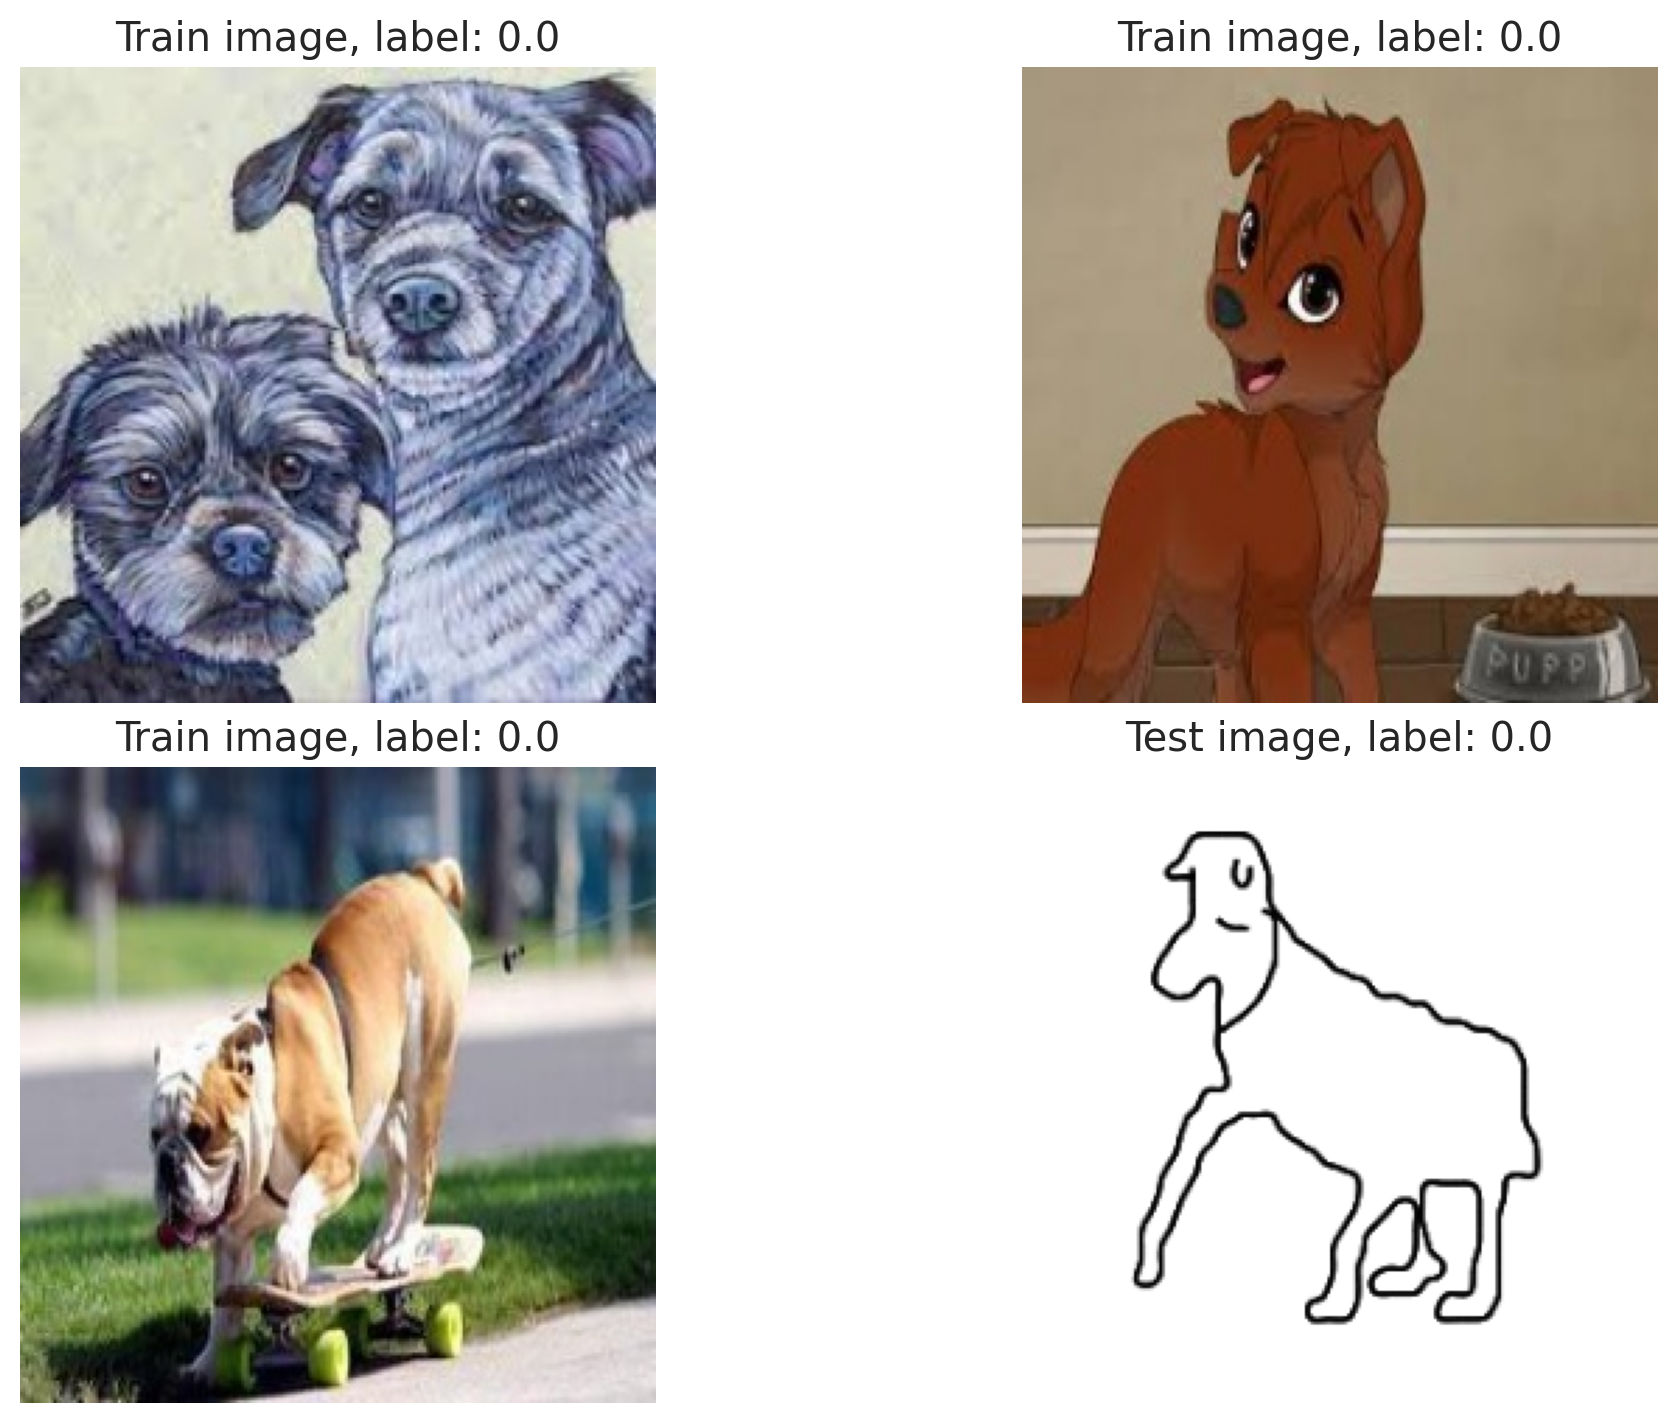

In [12]:
fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 2

img1, lbl1 = train_dataset[0]['image'].squeeze().permute(1,2,0), train_dataset[0]['label'].item()
img2, lbl2 = train_dataset[2000]['image'].squeeze().permute(1,2,0), train_dataset[2000]['label'].item()
img3, lbl3 = train_dataset[4000]['image'].squeeze().permute(1,2,0), train_dataset[4000]['label'].item()
img4, lbl4 = test_dataset[0]['image'].squeeze().permute(1,2,0), test_dataset[0]['label'].item()
  
fig.add_subplot(rows, columns, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Train image, label: ' + str(lbl1))
  
fig.add_subplot(rows, columns, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title('Train image, label: ' + str(lbl2))
  
fig.add_subplot(rows, columns, 3)
plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.title('Train image, label: ' + str(lbl3))

fig.add_subplot(rows, columns, 4)
plt.imshow(img4, cmap='gray')
plt.axis('off')
plt.title('Test image, label: ' + str(lbl4))

plt.show()

# ResNet18 Student Model

In [13]:
def visualize_metrics(metrics):
    clear_output()
    fig, ax = plt.subplots(len(domains), 2, figsize=(10,10))
    for i in range(len(domains)):
        ax[i][0].plot(metrics[i]['val_ac'], color="#67E46F", label='Val accuracy') 
        ax[i][0].plot(metrics[i]['train_ac'], color="#CB60D3", label='Train accuracy')
        ax[i][0].plot(metrics[i]['test_ac'], color="#E969A8", label='Test accuracy')
        ax[i][1].plot(metrics[i]['val_loss'], color="#67E46F", label='Val loss') 
        ax[i][1].plot(metrics[i]['train_loss'],  color="#CB60D3", label='Train loss')
        ax[i][1].plot(metrics[i]['test_loss'], color="#E969A8", label='Test loss')
        ax[i][0].set_ylabel('Accuracy')
        ax[i][0].set_xlabel('Epoch')
        ax[i][0].legend()
        ax[i][0].set_title('Test domain: ' + str(domains[i]))
        ax[i][1].legend()
        ax[i][1].set_ylabel('Loss')
        ax[i][1].set_xlabel('Epoch')
        ax[i][1].set_title('Test domain: ' + str(domains[i]))
    plt.show()
    for i in range(len(domains)):
        if len(metrics[i]['test_loss']) == 0:
            continue
        print(f"TEST RESULT ON DOMAIN {domains[i]} is {min(metrics[i]['test_loss'])}")

In [14]:
def train(model, optimizer, data_loader, loss_function):
    model.train()
    accuracy = 0 
    loss_sum = 0
    pbar = tqdm(data_loader)
    for batch in pbar:
        images, labels = batch["image"], batch["label"]
        images, labels = images.to(device).float(), labels.to(device).long()
        logits = model(images)
        loss = loss_function(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        loss_sum += loss.item() * images.shape[0]
        optimizer.step()

        ids = F.softmax(logits, dim=-1).argmax(dim=-1)
        batch_true = (ids == labels).sum() 
        accuracy += batch_true.item()
        pbar.set_description("Accuracy on batch %f loss on batch %f" % ((batch_true / images.shape[0]).item(), loss.item()))
    return accuracy / len(data_loader.dataset), loss_sum  / len(data_loader.dataset)

In [15]:
def test(model, data_loader, loss_function):
    with torch.inference_mode():
        model.eval()
        accuracy = 0 
        loss_sum = 0
        pbar = tqdm(data_loader)
        for batch in pbar:
            images, labels = batch["image"].to(device), batch["label"].to(device).long()
            logits = model(images)
            ids = F.softmax(logits, dim=-1).argmax(dim=-1)
            batch_true = (ids == labels).sum() 
            accuracy += batch_true.item()
            loss = loss_function(logits, labels)
            loss_sum += loss.item() * images.shape[0]
            pbar.set_description("Accuracy on batch %f loss on batch %f" % ((batch_true / images.shape[0]).item(), loss.item()))
        return accuracy / len(data_loader.dataset), loss_sum / len(data_loader.dataset)

In [16]:
def classification(model, optimizer, loss_function, batch_size, num_epochs, test_domain_ind, metrics, scheduler=None):
    train_loader, val_loader, test_loader = make_loaders(batch_size, test_domain_ind)
    val_ac, val_loss, train_ac, train_loss, test_ac, test_loss = [], [], [], [], [] ,[]

    for i in range(1, num_epochs + 1):

        tr_ac, tr_l = train(model, optimizer, train_loader, loss_function) 
        metrics[test_domain_ind]['train_ac'].append(tr_ac)
        metrics[test_domain_ind]['train_loss'].append(tr_l) 
        v_ac, v_l = test(model, val_loader, loss_function)
        metrics[test_domain_ind]['val_ac'].append(v_ac) 
        metrics[test_domain_ind]['val_loss'].append(v_l)
        t_ac, t_l = test(model, test_loader, loss_function)
        metrics[test_domain_ind]['test_ac'].append(t_ac) 
        metrics[test_domain_ind]['test_loss'].append(t_l)
        visualize_metrics(metrics)
        if scheduler is not None:
            scheduler.step()

In [17]:
from collections import defaultdict
def classification_all_domains(loss_function, batch_size, num_epochs, create_model, model_name, scheduler=None):
    metrics = {i : defaultdict(lambda: []) for i in range(len(domains))}
    for i in range(len(domains)):
        model = create_model()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        classification(model, optimizer, loss_function, batch_size, num_epochs, i, metrics, scheduler)
        path_model = f"./models/model_{model_name}_test_domain_{domains[i]}_{num_epochs}_epochs.pth"
        torch.save({'model_state_dict': model.state_dict()}, path_model)

In [18]:
def create_student_model():
    student_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    student_model.fc = nn.Linear(512, 7)
    student_model = student_model.to(device)
    return student_model

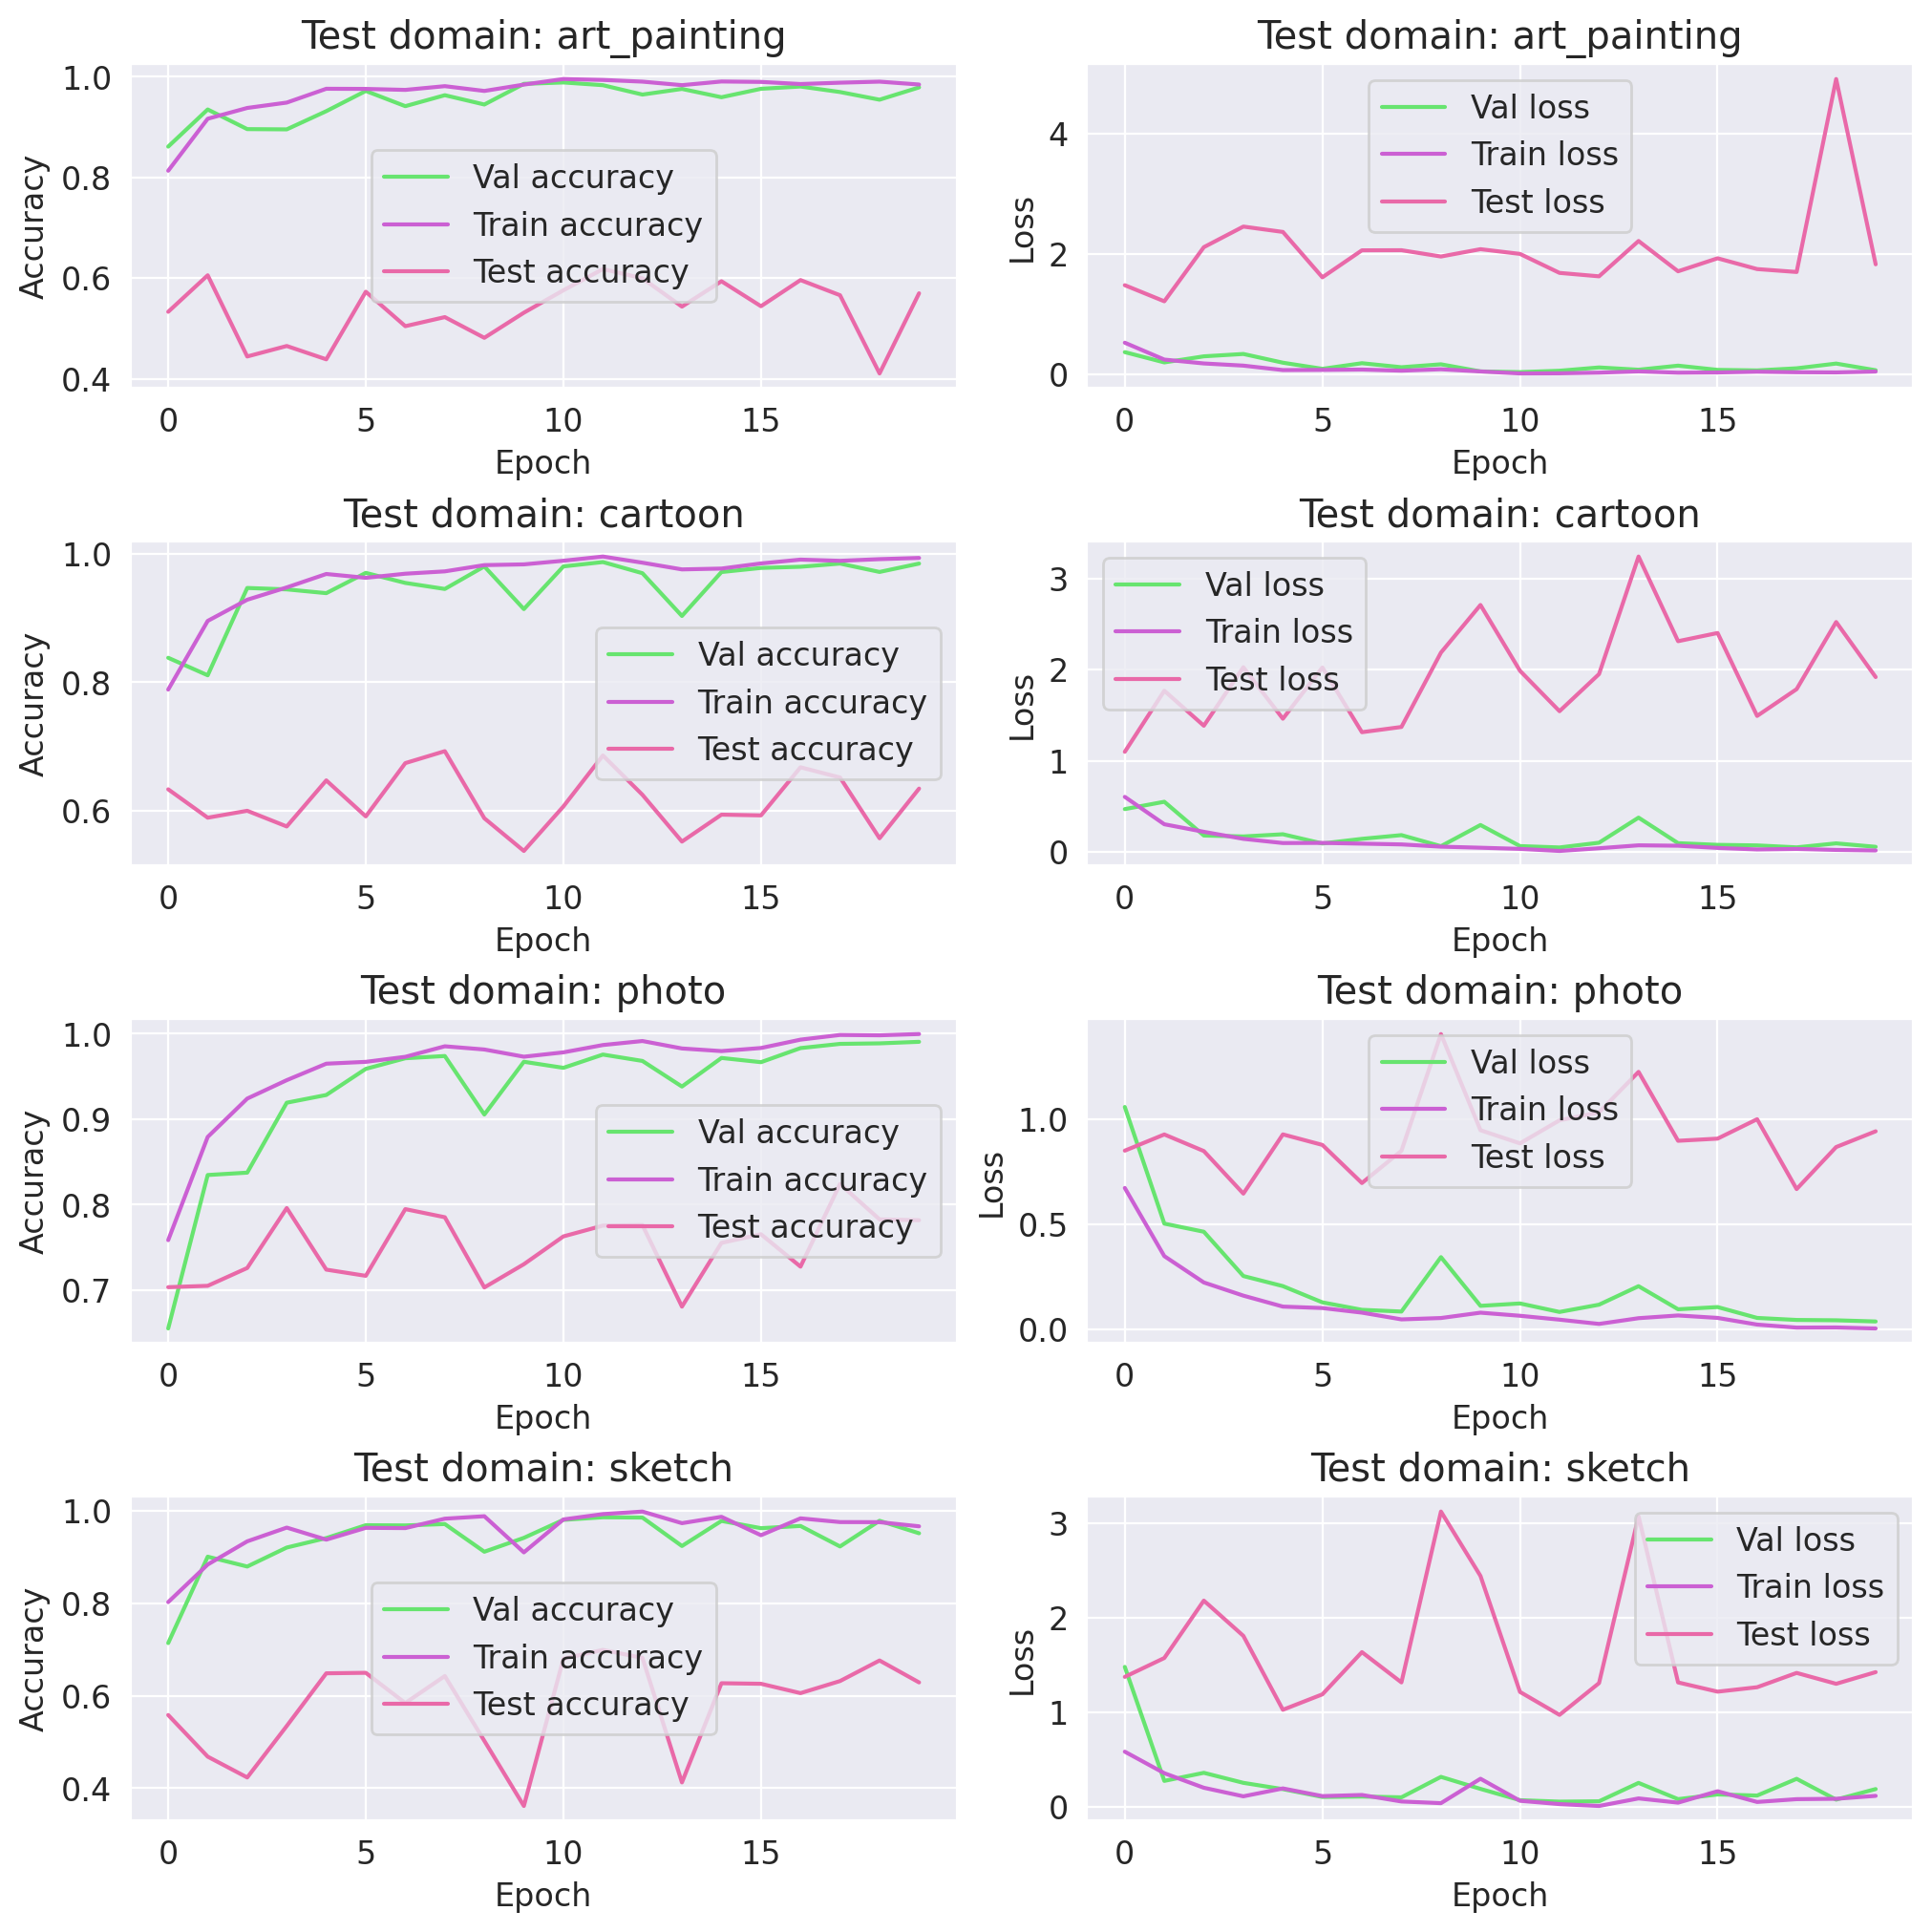

TEST RESULT ON DOMAIN art_painting is 1.213260571161906
TEST RESULT ON DOMAIN cartoon is 1.0984481252517306
TEST RESULT ON DOMAIN photo is 0.6447192889928604
TEST RESULT ON DOMAIN sketch is 0.971073771809445
CPU times: user 13h 18min 30s, sys: 28min 50s, total: 13h 47min 21s
Wall time: 2h 32min 38s


In [19]:
%%time
classification_all_domains(nn.CrossEntropyLoss(), 64, 20, create_student_model,'resnet18', scheduler=None)

# ResNet 50 Teacher Model

In [20]:
def create_teacher_model():
    teacher_model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
    teacher_model.fc = nn.Linear(2048, 7)
    teacher_model = teacher_model.to(device)
    return teacher_model

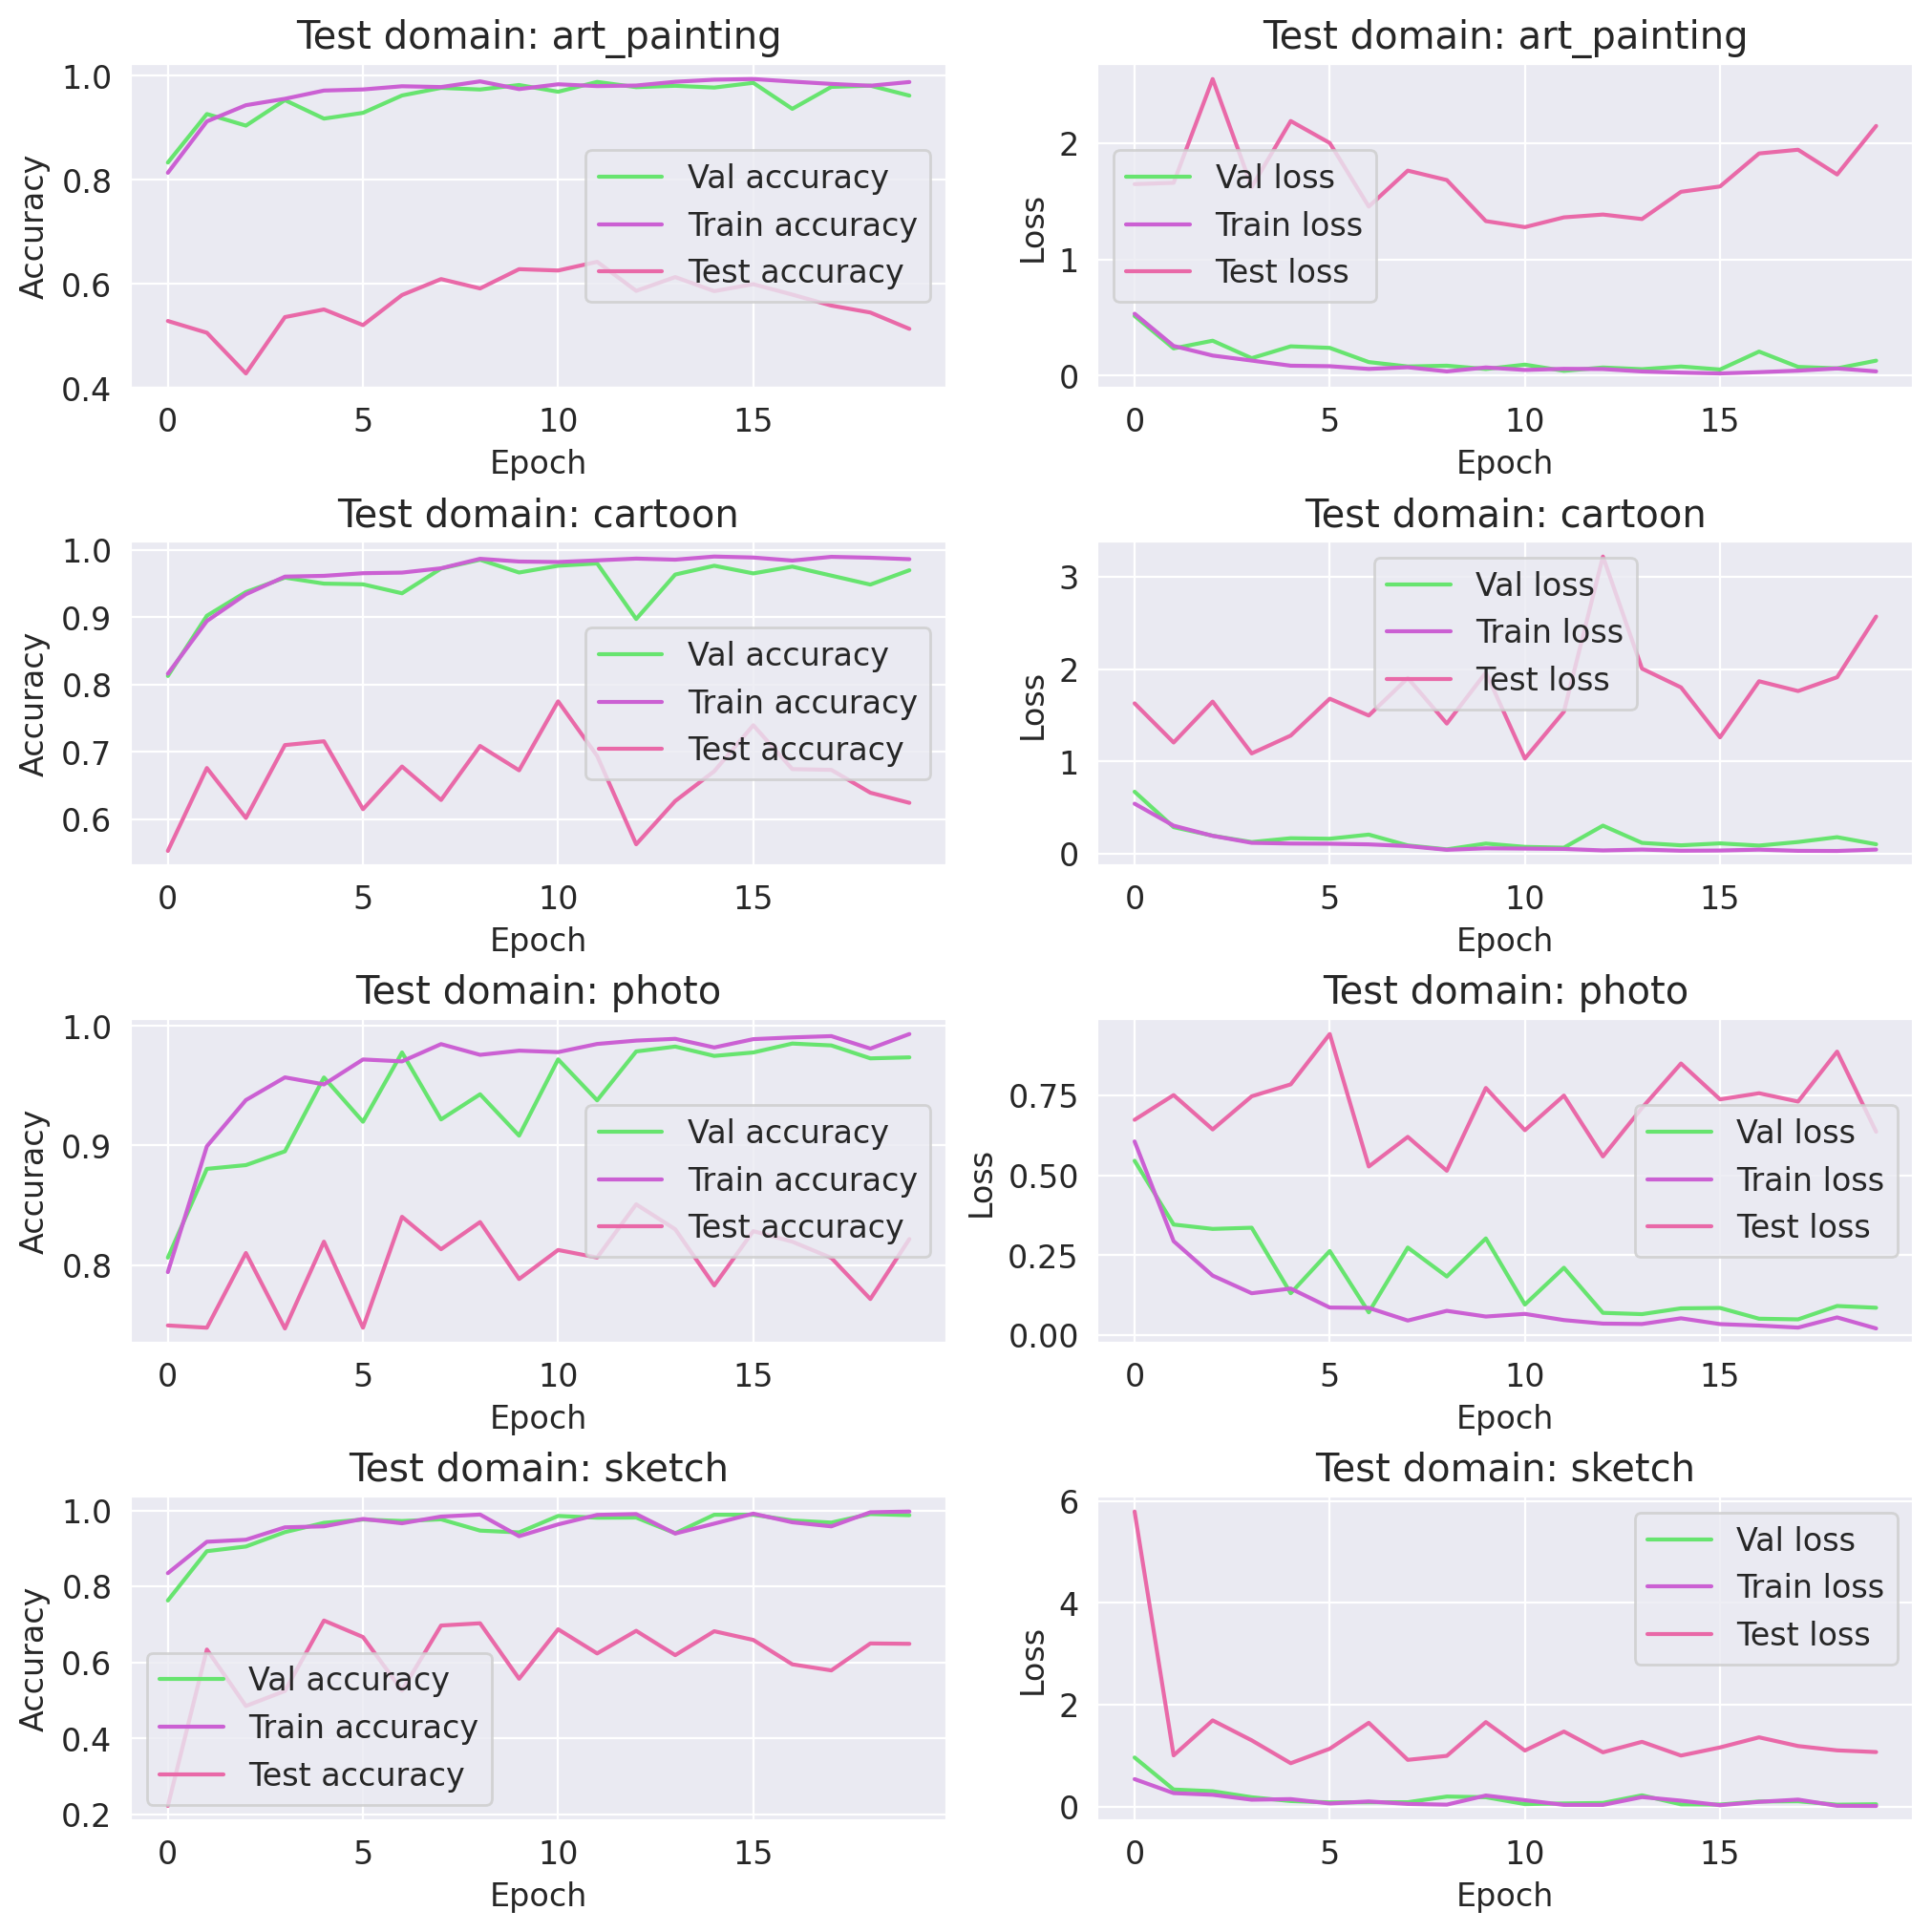

TEST RESULT ON DOMAIN art_painting is 1.2766838912610654
TEST RESULT ON DOMAIN cartoon is 1.0304704274964638
TEST RESULT ON DOMAIN photo is 0.5141960399704351
TEST RESULT ON DOMAIN sketch is 0.8515503435208395
CPU times: user 15h 7min 54s, sys: 30min 42s, total: 15h 38min 37s
Wall time: 3h 9min 59s


In [21]:
%%time
classification_all_domains(nn.CrossEntropyLoss(), 64, 20, create_teacher_model,'resnet50', scheduler=None)

# Distillation

In [22]:
def dist_train(student_model, teacher_model, optimizer, data_loader, temperature):
    student_model.train()
    accuracy = 0 
    loss_sum = 0
    loss_distillation = nn.KLDivLoss(reduction='batchmean')
    pbar = tqdm(data_loader)
    for batch in pbar:
        images, labels = batch["image"], batch["label"]
        images, labels = images.to(device).float(), labels.to(device).long()

        with torch.inference_mode():
            logits_teacher = teacher_model(images)
    
        logits_student = student_model(images)
        probs_student, probs_teacher = F.log_softmax(logits_student, dim=-1), F.softmax(logits_teacher / temperature, dim=-1)
        loss = loss_distillation(probs_student, probs_teacher)

        loss_sum += loss.item() * images.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ids = F.softmax(logits_student, dim=-1).argmax(dim=-1)
        batch_true = (ids == labels).sum() 
        accuracy += batch_true.item()
        pbar.set_description("Accuracy on batch %f loss on batch %f" % ((batch_true / images.shape[0]).item(), loss.item()))
    return accuracy / len(data_loader.dataset), loss_sum / len(data_loader.dataset)

In [23]:
def dist_test(student_model, teacher_model, data_loader, temperature):
    student_model.eval()
    accuracy = 0 
    loss_sum = 0
    loss_distillation = nn.KLDivLoss(reduction='batchmean')
    pbar = tqdm(data_loader)
    for batch in pbar:
        images, labels = batch["image"].to(device), batch["label"].to(device).long()
        with torch.inference_mode():
            logits_teacher = teacher_model(images)
            logits_student = student_model(images)
            probs_student, probs_teacher = F.log_softmax(logits_student, dim=-1), F.softmax(logits_teacher / temperature, dim=-1)
            loss = loss_distillation(probs_student, probs_teacher)
            loss_sum += loss.item() * images.shape[0]
        ids = F.softmax(logits_student, dim=-1).argmax(dim=-1)
        batch_true = (ids == labels).sum() 
        accuracy += batch_true.item()        
        pbar.set_description("Accuracy on batch %f loss on batch %f" % ((batch_true / images.shape[0]).item(), loss.item()))
    return accuracy / len(data_loader.dataset), loss_sum / len(data_loader.dataset)

In [24]:
def dist_classification(student_model, teacher_model, optimizer,batch_size, temperature, num_epochs, test_domain_ind, metrics, scheduler=None):
    train_loader, val_loader, test_loader = make_loaders(batch_size, test_domain_ind)
    val_ac, val_loss, train_ac, train_loss, test_ac, test_loss = [], [], [], [], [] ,[]

    for i in range(1, num_epochs + 1):

        tr_ac, tr_l = dist_train(student_model, teacher_model, optimizer, train_loader, temperature) 
        metrics[test_domain_ind]['train_ac'].append(tr_ac)
        metrics[test_domain_ind]['train_loss'].append(tr_l) 
        v_ac, v_l = dist_test(student_model, teacher_model, val_loader, temperature)
        metrics[test_domain_ind]['val_ac'].append(v_ac) 
        metrics[test_domain_ind]['val_loss'].append(v_l)
        t_ac, t_l = dist_test(student_model, teacher_model, test_loader, temperature)
        metrics[test_domain_ind]['test_ac'].append(t_ac) 
        metrics[test_domain_ind]['test_loss'].append(t_l)
        visualize_metrics(metrics)
        if scheduler is not None:
            scheduler.step()

In [25]:
from collections import defaultdict
def dist_classification_all_domains(batch_size, temperature, num_epochs, create_student_model, student_model_name, create_teacher_model, teacher_model_name, scheduler=None):
    metrics = {i : defaultdict(lambda: []) for i in range(len(domains))}
    for i in range(len(domains)):
        student_model = create_student_model()
        optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
        path_teacher_model = f"./models/model_{teacher_model_name}_test_domain_{domains[i]}_{num_epochs}_epochs.pth"
        checkpoint = torch.load(path_teacher_model)
        teacher_model = create_teacher_model()
        teacher_model.load_state_dict(checkpoint['model_state_dict'])
        for param in teacher_model.parameters():
            param.requires_grad = False

        dist_classification(student_model, teacher_model, optimizer, batch_size, temperature, num_epochs, i, metrics, scheduler)
        path_model = f"./models/model_{student_model_name}_test_domain_{domains[i]}_num_epochs_{num_epochs}_temperature_{temperature}.pth"
        torch.save({'model_state_dict': student_model.state_dict()}, path_model)

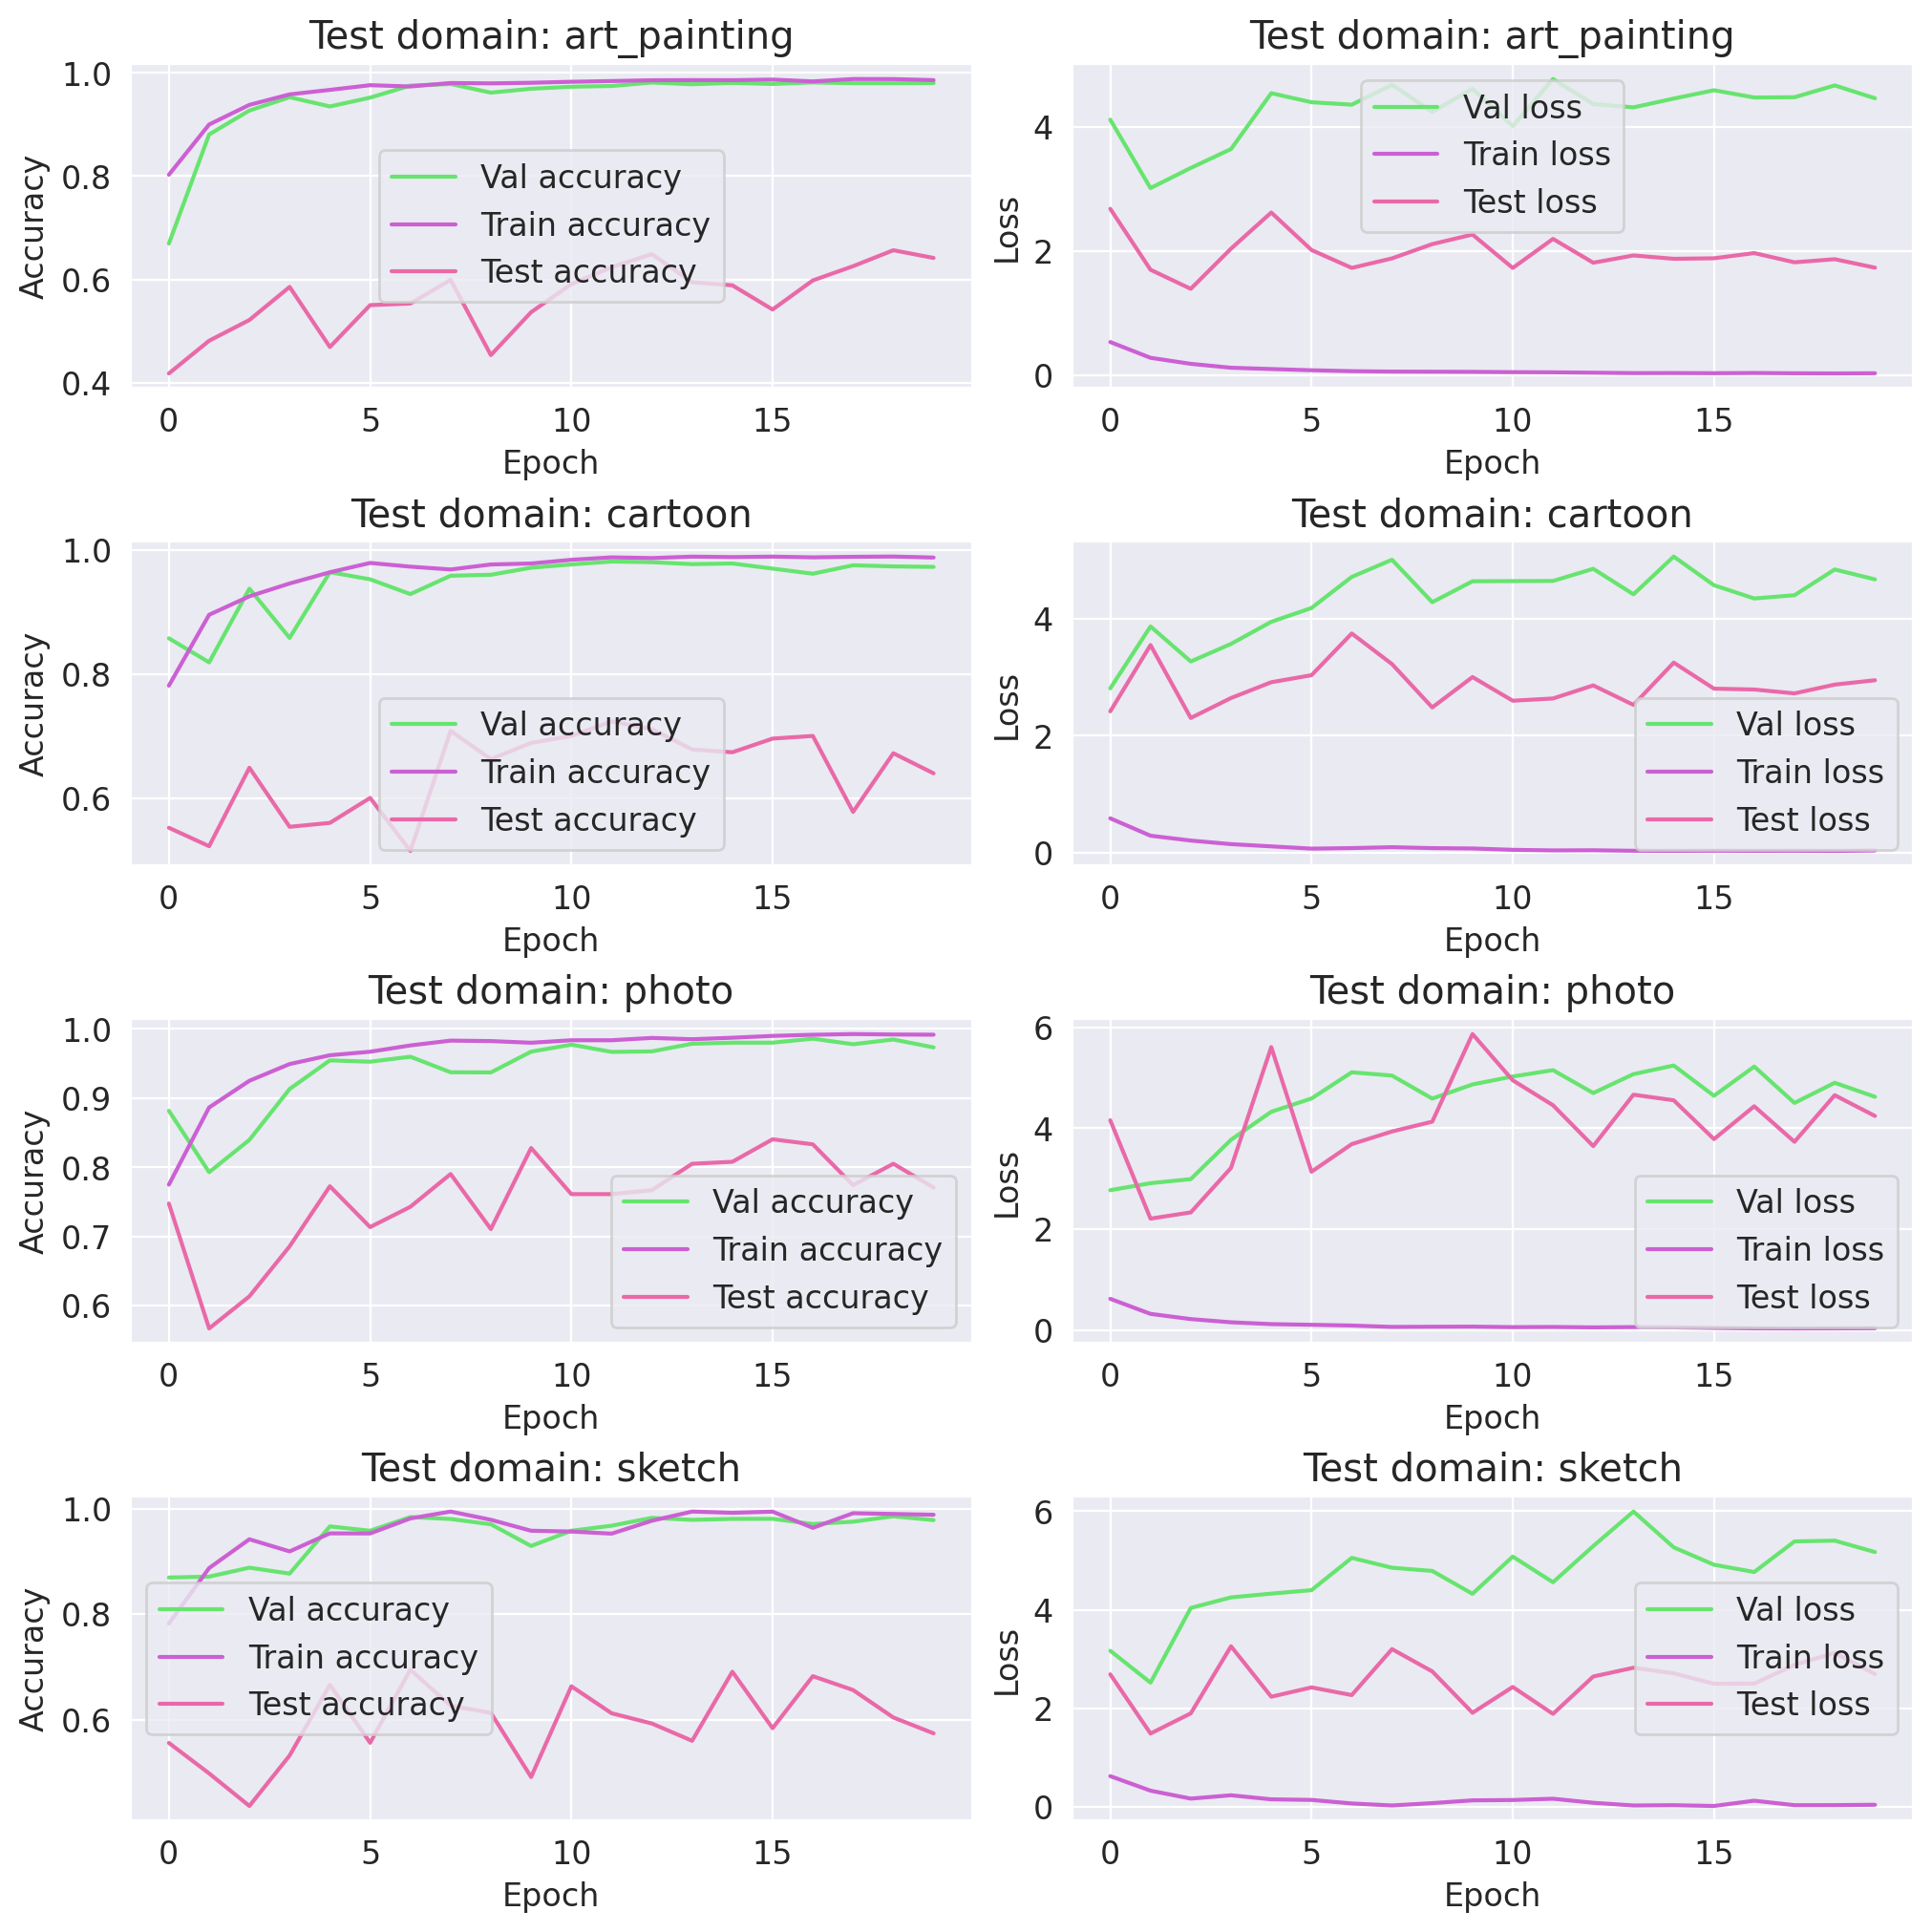

TEST RESULT ON DOMAIN art_painting is 1.3936874787993883
TEST RESULT ON DOMAIN cartoon is 2.302682975200395
TEST RESULT ON DOMAIN photo is 2.2052192856137705
TEST RESULT ON DOMAIN sketch is 1.4901011649149671
CPU times: user 16h 35min 41s, sys: 32min 20s, total: 17h 8min 1s
Wall time: 3h 12min 34s


In [26]:
%%time
dist_classification_all_domains(64, 1, 20, create_student_model,'distilled_resnet18', create_teacher_model, 'resnet50', scheduler=None)

In [ ]:
%%time
dist_classification_all_domains(64, 2, 20, create_student_model,'distilled_resnet18', create_teacher_model, 'resnet50', scheduler=None)

In [ ]:
%%time
dist_classification_all_domains(64, 4, 20, create_student_model,'distilled_resnet18', create_teacher_model, 'resnet50', scheduler=None)

In [ ]:
%%time
dist_classification_all_domains(64, 8, 20, create_student_model,'distilled_resnet18', create_teacher_model, 'resnet50', scheduler=None)